In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import decoupler as dc
import sc_toolbox
import random
import seaborn.objects as so

Installed version 0.12.1 of sc-toolbox is outdated. Newest version is 0.12.3!

In [2]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

sys.path = sys.path + ["/well/immune-rep/users/vbw431/python_utils/"]

In [3]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.ipython.ggplot import image_png

#sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/lib/python3.8/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [4]:
%%R
.libPaths(c(paste0("/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/r_modules"), .libPaths()))

library(tidyverse)
library(Seurat)


cur.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/out/"
references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"
com.out = "/well/immune-rep/users/vbw431/Projects/Peppa/reference_combat/"

##plotting
library(ggplot2); theme_set(theme_bw(base_size = 18)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x purrr::%@%()                 masks rlang::%@%()
x lazyeval::as_name()          masks rlang::as_name()
x lazyeval::call_modify()      masks rlang::call_modify()
x lazyeval::call_standardise() masks rlang::call_standardise()
x lazyeval::expr_label()       masks rlang::expr_label()
x lazyeval::expr_text()        masks rlang::expr_text()
x lazyeval::f_env()            masks rlang::f_env()
x lazyeval::f_env<-()          masks rlang::f_env<-()
x lazyeval::f_label()          masks rlang::f_label()
x lazyeval::f_lhs()            masks rlang::f_lhs()
x lazyeval::f_lhs<-()          masks rlang::f_lhs<-()
x lazyeval::f_rhs()            masks rlang::f_rhs()
x lazyeval::f_rhs<-() 

In [5]:
%%R
dge_list <- readRDS(paste0(out.dir, "/deg_list_NK.rds"))

In [6]:
%%R
## Perform XGR enrichment on HBV vs HBV_HIV
library(XGR)
DEG_list_NK <- dge_list

categories <- c("HBVvsHBV_HIV")

#Prepare vector of significant positive and negative logFC genes
n_pos<-vector('double', length(categories))
n_neg<-vector('double', length(categories))
n<-vector('double', length(categories))
for(i in 1:length(categories)){
  n_pos[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC>0)))
  n_neg[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC<0)))
  n[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05)))
}
min(n)
names(n_pos) <- categories
names(n_neg) <- categories
names(n) <- categories

#Prepare as input 
sig_gene_induced<-list()
sig_gene_suppressed<-list()
summary_df<-list()

for(i in 1:length(categories)){
  summary_df[[i]]<-DEG_list_NK[[i]]
  summary_df[[i]]<-as.data.frame(summary_df[[i]])
  summary_df[[i]]$log10p <- -log10(summary_df[[i]]$p_val_adj)
  summary_df[[i]]$sig <- ifelse(summary_df[[i]]$p_val_adj >= 0.05 | summary_df[[i]]$p_val_adj %in% NA, "no", "sig")
  summary_df[[i]]$change <- case_when(summary_df[[i]]$avg_log2FC > 0 & summary_df[[i]]$sig == "sig" ~ "Induced", 
                                      summary_df[[i]]$avg_log2FC < 0 & summary_df[[i]]$sig == "sig" ~ "Suppressed",
                                      summary_df[[i]]$sig %in% "no" ~ "None")
  summary_df[[i]]$x <- summary_df[[i]][,'avg_log2FC']
  summary_df[[i]]$y <- summary_df[[i]][,'log10p']
  summary_df[[i]]$colour <- summary_df[[i]][,'change']
  sig_gene_induced[[i]]<-summary_df[[i]] %>% filter(change == 'Induced') %>% arrange(-avg_log2FC) %>% head(n=min(n_pos))
  sig_gene_suppressed[[i]]<-summary_df[[i]] %>% filter(change == 'Suppressed') %>% arrange(avg_log2FC) %>% head(n=min(n_neg))
  summary_df[[i]]$label_2 <- ifelse(summary_df[[i]]$gene %in% c(sig_gene_induced[[i]]$gene, sig_gene_suppressed[[i]]$gene), paste(summary_df[[i]]$gene), paste(''))
}
head(summary_df[[i]])

names(sig_gene_induced) <- categories
names(sig_gene_suppressed) <- categories
names(summary_df)<- categories


In [7]:
%%R
#Run the XGR here

pathway_list<-list()

i = "HBVvsHBV_HIV"

background <- unique(toupper(as.character(DEG_list_NK[[i]]$gene)))
induced <- sig_gene_induced[[i]]$gene
suppressed <- sig_gene_suppressed[[i]]$gene
    
List <- list(induced, suppressed)
Condition <- list("overexpressed", "suppressed")
Output <- vector(mode = "list", length = length(List))
    
ontology = "MsigdbC2REACTOME" # alternative is ontology = "pathway" or something like that
    

for(j in seq_along(List)) {
      tryCatch({
        Output[[j]] <- xEnricherGenes(data = List[[j]], background = background, ontology = ontology,
                                      test = "binomial", min.overlap = 2)
        #Output[[j]] <- xEnrichConciser(Output[[j]])
        Output[[j]] <- xEnrichViewer(Output[[j]], top_num = 30, details = T, sortBy="fdr")
        Output[[j]]$direction <- Condition[[j]]
      }, error=function(e){cat("ERROR :",conditionMessage(e), "\n")})
    }
    




In [8]:
%%R
pathway <- rbind(Output[[1]], Output[[2]])
pathway <- data.frame(pathway)
pathway$fc <-ifelse(pathway$direction %in% "suppressed",
             pathway$fc * (-1),
             pathway$fc)

pathway$pathway <- row.names(pathway)
pathway$pathway <- factor(pathway$pathway, levels = c(row.names(pathway[order(pathway$fc), ])))
#pathway <- pathway[pathway$adjp < 0.05, ]
pathway$label_adj <- case_when(pathway$direction %in% "overexpressed" ~ -1,
                               pathway$direction %in% "suppressed" ~ 1)
    
pathway$category<-"NK"
pathway_list[[i]]<-pathway
    

pathway<-plyr::ldply(pathway_list, rbind) 



In [9]:
%%R
#NOW WE DO BIG V SMALL EC BALLPLOT
#Here we just have to modify the pathway number for the duplicated pathways as those with duplicates are given a suffix of '1' by XGR

duplicated_pathways<-as.character(unlist(pathway %>% group_by(category) %>% add_count(name) %>% dplyr::filter(n>1) %>% ungroup() %>% dplyr::select(name) %>% unique()))
pathway<-pathway %>%  group_by(category, name) %>% dplyr::slice(which.max(nOverlap)) %>% ungroup()
pathway$pathway<-ifelse(pathway$category=='HBV' & pathway$name %in% duplicated_pathways, str_sub(pathway$pathway, end=-2), paste(pathway$pathway))

#And modify to create a log scale, remove duplicates and colour the text in line with the data     
pathway$pos_FC<-sqrt(pathway$fc^2)
pathway$pos_log10FC<-log10(pathway$pos_FC)
pathway$log10FC<-ifelse(pathway$fc<0, pathway$pos_log10FC*-1, pathway$pos_log10FC)




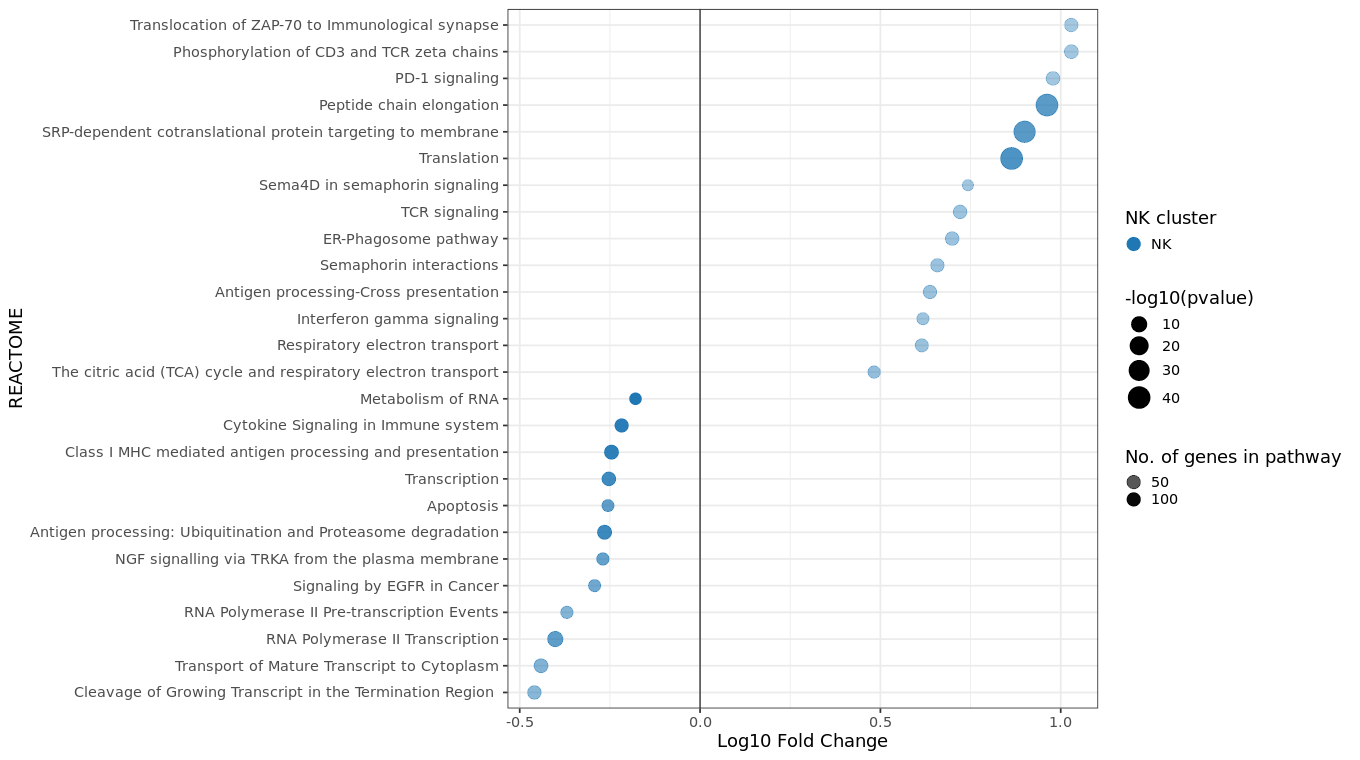

In [10]:
%%R -w 1360 -h 760

allnk_reactome_hbv_co <- pathway
ballplot <- allnk_reactome_hbv_co %>% 
  filter(nOverlap >=2)%>%
  filter(!grepl("43S|ATP|Influenza|degredation|HIV|Circa|cone|Exon|Cell Cycle|BCR|messenger|Immune System|Adaptive Immune|Metabolism of proteins|mRNA|Platelet|Hemos|regula", name)) %>%
ggplot()+
  geom_point(aes(x=reorder(name, fc), y=log10FC, size=-log10(pvalue), alpha=nOverlap, colour=category))+
   scale_size(range=c(5,10))+
    guides(color = guide_legend(override.aes = list(size=6)), alpha = guide_legend(override.aes = list(size=6)))+
    labs(colour='NK cluster', alpha='No. of genes in pathway')+
  ggsci::scale_color_d3() +
  scale_alpha_continuous(n.breaks=4,range = c(0.4, 1))+
  coord_flip()+
  xlab('REACTOME')+
  ylab('Log10 Fold Change')+
  geom_hline(yintercept = 0)+
  theme_bw(base_size=18)

print(ballplot)

ggsave("/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/HBV_co_allNK.pdf", width = 11, height = 7)


In [11]:
%%R
merge_degs <- lapply(names(dge_list), function(x){
    dge_list[[x]] = dge_list[[x]]%>% filter(p_val_adj < 0.05)
    dge_list[[x]]$contrast = x
    return(dge_list[[x]])
})

merge_degs <- data.table::rbindlist(merge_degs)


`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


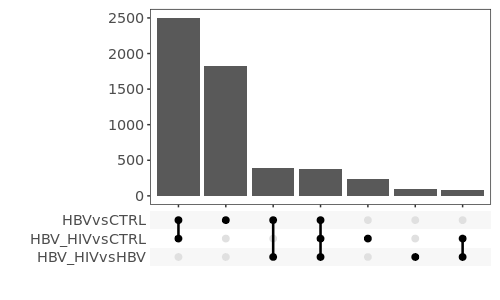

In [12]:
%%R -h 300 -w 500
## upset / venn plot

library(ggupset)
NK_degs <- merge_degs %>% filter(p_val_adj < 0.05)


upsetplot_NK <- NK_degs %>%
  group_by(annotation, gene) %>%
  summarize(contrast = list(contrast))%>%
ggplot(aes(contrast))+
geom_bar()+
scale_x_upset()+
xlab("")+
ylab("")

print(upsetplot_NK)


In [13]:
%%R
head(merge_degs)

   p_val avg_log2FC pct.1 pct.2 p_val_adj   gene annotation  contrast
1:     0  0.4395997 0.997 0.999         0   ACTB         NK HBVvsCTRL
2:     0  0.5403689 0.919 0.860         0  ACTG1         NK HBVvsCTRL
3:     0  0.6680734 0.867 0.792         0 CORO1A         NK HBVvsCTRL
4:     0  0.4367044 0.986 0.982         0   CST7         NK HBVvsCTRL
5:     0  0.4394365 0.978 0.968         0   CYBA         NK HBVvsCTRL
6:     0  0.3436277 1.000 0.999         0  HLA-A         NK HBVvsCTRL


In [14]:
%%R
# Load library
library("ggvenn")

split <- split(merge_degs, merge_degs$contrast)

dge_genes <- lapply(split, function(x){
    y <- x$gene
return(y)})

print(names(dge_genes))
category.names = c("Co-infection vs. CTRL" , "Co-infection vs. HBV", "HBV vs. CTRL")
names(dge_genes) <- category.names

# Chart
vennplot <- ggvenn(dge_genes)+ggsci::scale_fill_jama()
vennplot

ggsave(vennplot, file="/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/venn_update.pdf", device="pdf",  width = 6, height = 6, units = "in")


[1] "HBV_HIVvsCTRL" "HBV_HIVvsHBV"  "HBVvsCTRL"    
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [15]:
%%R
head(dge_genes[[3]])

[1] "ACTB"   "ACTG1"  "CORO1A" "CST7"   "CYBA"   "HLA-A" 


## Volcano plot of shared DEGs in infected individuals

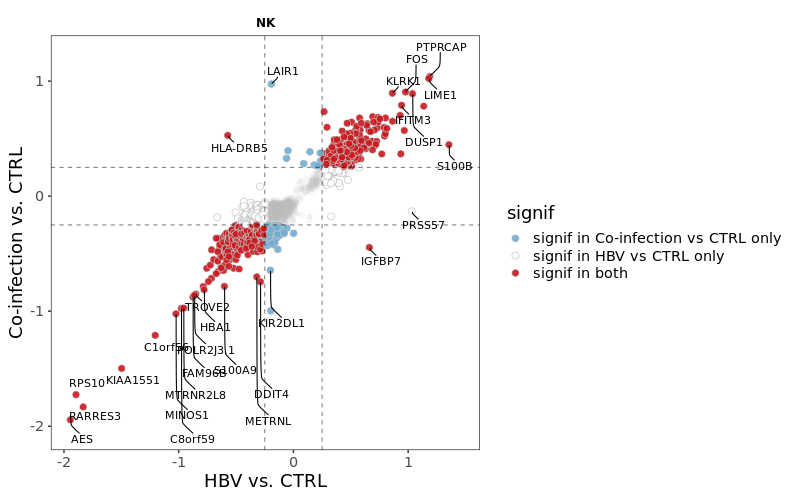

In [16]:
%%R -h 500 -w 800
CTRL_degs <- merge_degs %>%
filter(grepl("CTRL", contrast)) %>%
mutate(signif =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, "signif", NA))%>%
mutate(labels =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, gene, NA))


CTRL_degs <- split(CTRL_degs, CTRL_degs$contrast)
cross_df <- CTRL_degs[["HBVvsCTRL"]] %>%
full_join(CTRL_degs[["HBV_HIVvsCTRL"]], by=c("gene", "annotation")) %>%
mutate(signif = ifelse(signif.x == "signif" & is.na(signif.y), "signif in HBV vs CTRL only",
                            ifelse(is.na(signif.x) & signif.y == "signif", "signif in Co-infection vs CTRL only", 
                                  ifelse(signif.x == "signif" & signif.y == "signif", "signif in both",NULL)))) %>%
mutate(labels = ifelse(signif.x == "signif" & is.na(signif.y), gene,
                            ifelse(is.na(signif.x) & signif.y == "signif", gene, 
                                  ifelse(signif.x == "signif" & signif.y == "signif", gene,NA))))  

bivolplot <- cross_df %>%
ggplot(aes(avg_log2FC.x, avg_log2FC.y))+
geom_point(size=2,color = "gray", alpha=0.1)+
geom_point(data = cross_df %>% filter(!is.na(signif)), color="white",size=3)+
geom_point(data = cross_df %>% filter(!is.na(signif)), aes(fill = signif), size=3,shape = 21, color= "gray", alpha=0.9)+
facet_wrap(~annotation)+
ggrepel::geom_text_repel(aes(label = labels),
                         nudge_x = .1,
    box.padding = 0.5,
    nudge_y = -0.1,
    segment.curvature = -0.1,
    segment.ncp = 4,
    segment.angle = 20,
    direction = "y",
    max.time = 5, 
    max.iter = 100000,
    force=10,
    force_pull=1,
    max.overlaps=15)+
geom_hline(yintercept = c(0.25, -0.25), linetype="dashed", alpha=0.5)+
geom_vline(xintercept = c(0.25, -0.25), linetype="dashed", alpha=0.5)+
scale_fill_manual(values = c("#6baed6","#ffffff","#cb181d"))+
xlab("HBV vs. CTRL")+
ylab("Co-infection vs. CTRL")


bivolplot


In [17]:
%%R
ggsave(bivolplot, file="/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_bivolplot.pdf", device="pdf",  width = 11, height = 7, units = "in")


In [18]:
%%R
#.libPaths(c(paste0("/well/immune-rep/users/vbw431/python/test_immcantation-skylake/r_modules"), .libPaths()))
library(XGR)

enrich_infection = cross_df %>%
filter(grepl("signif in both", signif)) %>% 
filter(avg_log2FC.x >0 & avg_log2FC.y >0)



data <- enrich_infection$gene

ontology = "MsigdbC2REACTOME"

eTerm_infection <- xEnricherGenes(data=data, ontology=ontology, test = "binomial",min.overlap = 2) %>%
        xEnrichConciser()
upregulated <- xEnrichViewer(eTerm_infection, 20, details = T)



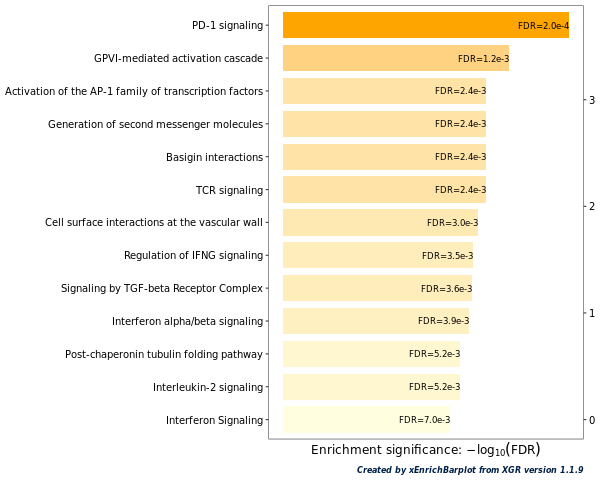

In [19]:
%%R -w 600
##enriched pathways in HBV Adaptive
bp <- xEnrichBarplot(upregulated %>%
                       filter(!grepl("Immune System|Adaptive Immune|Metabolism of proteins|mRNA|Platelet|Hemos|regula", name)), 
                     top_num='auto', displayBy="fdr")
print(bp)

ggsave("/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/infection_vs_ctrl_enrich.pdf", width = 6, height = 3)


## Plot heatmap of top DGE in infection

In [20]:
## load coding gene reference
with open("/well/immune-rep/users/vbw431/Projects/Fairfax/Mel_all/data/coding_genes_noIg.txt") as f:
    coding = f.read().splitlines() 


In [21]:
%%R
##load seurat obj and preprocess as per dge calculation
peppa <- readRDS(paste0(out.dir, "/peppa_pbmc_all.rds"))
peppa <- subset(peppa, subset = celltype_consensus.l1 == "NK")
peppa <- subset(peppa, subset = celltype_consensus.l1 == "NK")
##filter pre vaccination samples and pre treatment samples out
peppa <- subset(peppa, subset = Treatment_status != "Pre_treatment")

trim_barcodes <- peppa@meta.data %>% 
  dplyr::select(orig.ident) %>%
  dplyr::filter(grepl("_0|SeuratProject", orig.ident))
table(trim_barcodes)

peppa <- subset(peppa, cells = rownames(trim_barcodes))

##remove CD16 bright to correlate transcriptome with ADCC data (CD56bright lack CD16 and not thought to contribute to ADCC)
##remove proliferating due to being a mix of NKcell types
peppa <- subset(peppa, subset = celltype_consensus.l2 != "NK.CD56bright")
peppa <- subset(peppa, subset = celltype_consensus.l2 != "NK.Prolifering")

##downsample evenly per cell subset per condition
set.seed(1)
adaptive_barcodes <- peppa@meta.data %>%
mutate(cells = rownames(.)) %>%
filter(grepl("NK.Adaptive$", celltype_consensus.l2))%>%
group_by(celltype_consensus.l2, study_disease) %>%
sample_n(2000,replace=FALSE) %>% 
ungroup() %>% 
select(cells) %>% 
unlist()

set.seed(1)
adaptive_chemo_barcodes <- peppa@meta.data %>%
mutate(cells = rownames(.)) %>%
filter(grepl("NK.Adaptive.CCL4.CCL3$", celltype_consensus.l2))%>%
group_by(celltype_consensus.l2, study_disease) %>%
sample_n(400,replace=FALSE) %>% 
ungroup() %>% 
select(cells) %>% 
unlist()

set.seed(1)
adaptive_mat_barcodes <- peppa@meta.data %>%
mutate(cells = rownames(.)) %>%
filter(grepl("NK.Mature$", celltype_consensus.l2))%>%
group_by(celltype_consensus.l2, study_disease) %>%
sample_n(500,replace=FALSE) %>% 
ungroup() %>% 
select(cells) %>% 
unlist()

downsample_cells <- c(adaptive_barcodes, adaptive_chemo_barcodes, adaptive_mat_barcodes)

peppa <- subset(peppa, cells = downsample_cells)

##Normalise data
peppa <- peppa %>%
  NormalizeData() %>%
  ScaleData()



In [22]:
%%R
pathwaygenes <- upregulated %>% 
arrange(adjp) %>%
head(10) %>%
select(name, members_Overlap)

head(pathwaygenes$members_Overlap)
split_genes <- strsplit(pathwaygenes$members_Overlap, ",")
pathwaygenes_genes<- unlist(split_genes)
pathwaygenes_genes <- gsub(" ", "", pathwaygenes_genes)
print(table(pathwaygenes_genes %in% rownames(peppa)))


TRUE 
  69 


In [23]:
%%R
dge_list <- readRDS(paste0(out.dir, "/deg_list_NK_subsets.rds"))
DEG_list_NK <-dge_list[["HBV_HIVvsHBV"]]

In [24]:
%%R
categories <- names(DEG_list_NK)
categories

[1] "NK.Adaptive.CCL4.CCL3" "NK.Adaptive"           "NK.Mature"            


In [25]:
%%R

categories <- names(DEG_list_NK)

n_pos<-vector('double', length(categories))
n_neg<-vector('double', length(categories))
n<-vector('double', length(categories))
for(i in 1:length(categories)){
  n_pos[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC>0)))
  n_neg[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC<0)))
  n[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05)))
}
min(n)

#And use these as input to the GOBP analysis 
sig_gene_induced<-list()
sig_gene_suppressed<-list()
summary_df<-list()
for(i in 1:length(categories)){
  summary_df[[i]]<-DEG_list_NK[[i]]
  summary_df[[i]]<-as.data.frame(summary_df[[i]])
  summary_df[[i]]$log10p <- -log10(summary_df[[i]]$p_val_adj)
  summary_df[[i]]$sig <- ifelse(summary_df[[i]]$p_val_adj > 0.049 | summary_df[[i]]$p_val_adj %in% NA, "no", "sig")
  summary_df[[i]]$change <- case_when(summary_df[[i]]$avg_log2FC > 0 & summary_df[[i]]$sig == "sig" ~ "Induced", 
                                      summary_df[[i]]$avg_log2FC < 0 & summary_df[[i]]$sig == "sig" ~ "Suppressed",
                                      summary_df[[i]]$sig %in% "no" ~ "None")
  summary_df[[i]]$x <- summary_df[[i]][,'avg_log2FC']
  summary_df[[i]]$y <- summary_df[[i]][,'log10p']
  summary_df[[i]]$colour <- summary_df[[i]][,'change']
  sig_gene_induced[[i]]<-summary_df[[i]] %>% filter(change == 'Induced') %>% arrange(-avg_log2FC) %>% head(n=min(n_pos))
  sig_gene_suppressed[[i]]<-summary_df[[i]] %>% filter(change == 'Suppressed') %>% arrange(avg_log2FC) %>% head(n=min(n_neg))
  summary_df[[i]]$label_2 <- ifelse(summary_df[[i]]$gene %in% c(sig_gene_induced[[i]]$gene, sig_gene_suppressed[[i]]$gene), paste(summary_df[[i]]$gene), paste(''))
}
names(summary_df)

NULL


In [26]:
%%R
#Run the REACTOME here
library(XGR)
REACTOME_list<-list()
for(i in 1:length(categories)){
  tryCatch({
    background <- as.character(DEG_list_NK[[i]]$gene)
    induced <- sig_gene_induced[[i]]$gene
    suppressed <- sig_gene_suppressed[[i]]$gene
    
    List <- list(induced, suppressed)
    Condition <- list("overexpressed", "suppressed")
    Output <- list()
    
    ontology = "MsigdbC2REACTOME" # alternative is ontology = "REACTOME" or something like that
    for(j in seq_along(List)) {
      tryCatch({
          print(paste0("running enrichR for ", categories[i]))
        Output[[j]] <- xEnricherGenes(data = List[[j]], background = background, ontology = ontology,
                                      test = "binomial", min.overlap = 2)
        #Output[[j]] <- xEnrichConciser(Output[[j]])
        Output[[j]] <- xEnrichViewer(Output[[j]], top_num = 30, details = T)
        Output[[j]]$direction <- Condition[[j]]
      }, error=function(e){cat("ERROR 1 :",conditionMessage(e), "\n")})
    }
    
    REACTOME <- rbind(Output[[1]], Output[[2]])
    REACTOME <- data.frame(REACTOME)
    REACTOME$fc <-
      ifelse(REACTOME$direction %in% "suppressed",
             REACTOME$fc * (-1),
             REACTOME$fc)
    REACTOME$REACTOME <- row.names(REACTOME)
    REACTOME$REACTOME <-
      factor(REACTOME$REACTOME, levels = c(row.names(REACTOME[order(REACTOME$fc), ])))
    REACTOME <- REACTOME[REACTOME$adjp < 0.0501, ]
    REACTOME$label_adj <- case_when(REACTOME$direction %in% "overexpressed" ~ -1,
                                REACTOME$direction %in% "suppressed" ~ 1)
    
    REACTOME$category<-categories[i]
    REACTOME_list[[i]]<-REACTOME
    
  }, error=function(e){cat("ERROR 2 :",conditionMessage(e), "\n")})
} 

REACTOME<-plyr::ldply(REACTOME_list, rbind) 


#NOW WE DO BIG V SMALL EC BALLPLOT
#Here we just have to modify the REACTOME number for the duplicated pathways as those with duplicates are given a suffix of '1' by XGR

duplicated_pathways<-as.character(unlist(REACTOME %>% group_by(category) %>% add_count(name) %>% dplyr::filter(n>1) %>% ungroup() %>% dplyr::select(name) %>% unique()))
REACTOME<-REACTOME %>%  group_by(category, name) %>% dplyr::slice(which.max(nOverlap)) %>% ungroup()
REACTOME$REACTOME<-ifelse(REACTOME$category=='HBV_HIV' & REACTOME$name %in% duplicated_pathways, str_sub(REACTOME$REACTOME, end=-2), paste(REACTOME$REACTOME))

#And modify to create a log scale, remove duplicates and colour the text in line with the data     
REACTOME$pos_FC<-sqrt(REACTOME$fc^2)
REACTOME$pos_log10FC<-log10(REACTOME$pos_FC)
REACTOME$log10FC<-ifelse(REACTOME$fc<0, REACTOME$pos_log10FC*-1, REACTOME$pos_log10FC)
REACTOME$category<-factor(REACTOME$category, levels = categories)

margin_spacer <- function(x) {
  # where x is the column in your dataset
  left_length <- nchar(levels(factor(x)))[1]
  if (left_length > 8) {
    return((left_length - 8) * 4)
  }
  else
    return(0)
}

[1] "running enrichR for NK.Adaptive.CCL4.CCL3"
[1] "running enrichR for NK.Adaptive.CCL4.CCL3"
[1] "running enrichR for NK.Adaptive"
[1] "running enrichR for NK.Adaptive"
[1] "running enrichR for NK.Mature"
ERROR 1 : subscript out of bounds 
[1] "running enrichR for NK.Mature"


In [27]:
%%R
#saveRDS(REACTOME, paste0(out.dir, "/REACTOME_NK.rds"))
#REACTOME <- readRDS(paste0(out.dir, "/REACTOME_NK.rds"))

NULL


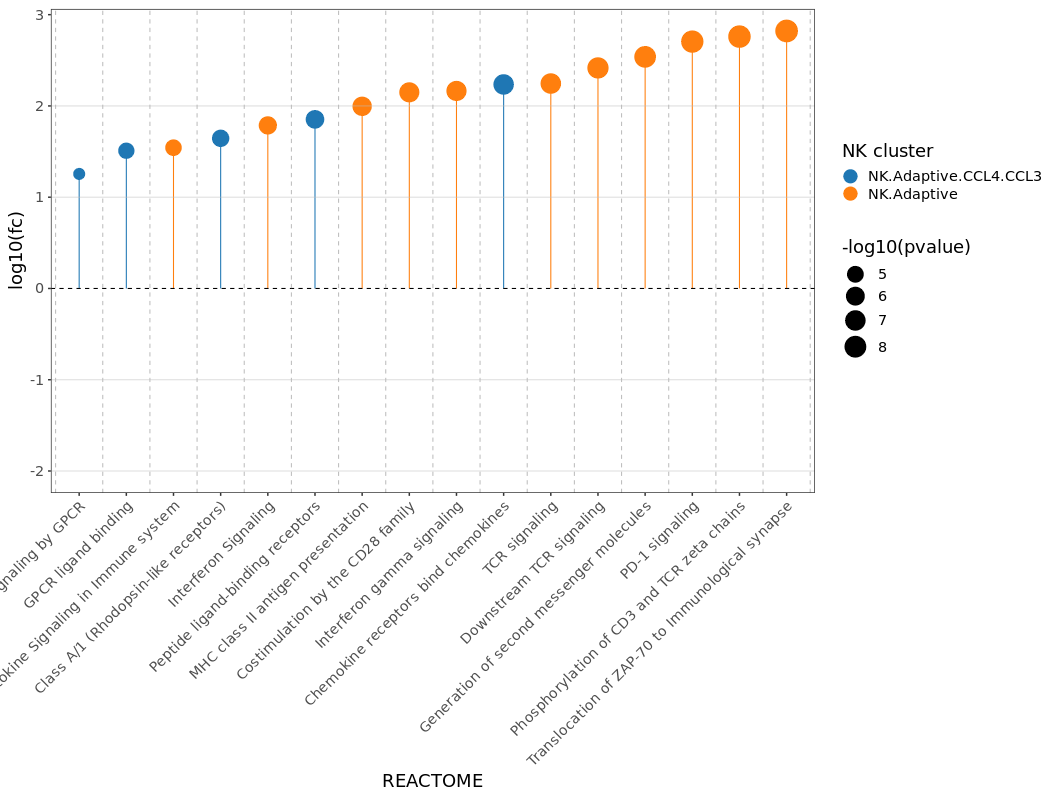

In [28]:
%%R -w 1060 -h 800
ballplot <- REACTOME %>% 
mutate(title = "HBV vs. HBV_HIV")%>%
  filter(nOverlap >=2)%>%
  filter(adjp <= 0.05)%>%
filter(log10FC>0) %>%
#filter(!grepl("PD-1|Phosphorylation of CD3|Respiratory|CD28|^TCR signaling|Activation of the mRNA|Nonsense|SRP|Sema|Peptide|UTR|43S|Vif|Metabolism of|HIV|Immune System|messenger molecules|Circadian|Translation|Influenza", name)) %>%
ggplot(aes(x=log10FC, y=reorder(name, log10FC), colour=category))+
geom_point(aes(size=-log10(pvalue)), position = position_dodge(width = .8))+
geom_errorbarh(aes(xmin = 0, xmax = log10FC),
                   height = 0,
                   position = position_dodge(width = .8))+
scale_size(range=c(5,10))+
    guides(color = guide_legend(override.aes = list(size=6)), alpha = guide_legend(override.aes = list(size=6)))+
    labs(colour='NK cluster', alpha='No. of genes in pathway')+
    #geom_line(aes(group =interaction(category, name)), size =1)+
  ggsci::scale_color_d3() +
  scale_alpha_continuous(n.breaks=4,range = c(0.4, 1))+
  ylab('REACTOME')+
  xlab('log10(fc)')+
geom_vline(lty = 2, xintercept = 0)+
geom_hline(lty = 2, yintercept=seq(from = 0.5, to = length(unique(REACTOME$name)), by = 1),color="gray", size = 0.5, alpha=1)+
geom_vline(xintercept=c(-2,-1,1,2),color="gray", size = 0.5, alpha=0.5)+
coord_flip()+
theme(axis.text.x = element_text(angle=45, hjust=1))
#facet_wrap(~category, ncol = 1, scales = "free_y")+
#scale_y_reordered()

#pdf(file = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_ballplot.pdf",width = 13,height = 8)
#plot(ballplot)
#dev.off()

print(ballplot)

In [29]:
%%R
genes_toplot_df <- REACTOME %>% as.data.frame %>% 
filter(grepl("gamma|Chemokine", name)) %>% 
select(name,members_Overlap)  

splitted <- strsplit(as.character(genes_toplot_df$members_Overlap), ",")

genes_toplot_long <- data.frame(name = rep.int(genes_toplot_df$name, sapply(splitted, length)), members_Anno = unlist(splitted))
genes_toplot_long$members_Anno <- gsub(" ", "", genes_toplot_long$members_Anno)

##remove duplicated genes across multiple pathways (we will take the first pathway)
genes_toplot_long <- genes_toplot_long %>%
group_by(members_Anno) %>%
dplyr::slice(1)


rownames(genes_toplot_long) <- genes_toplot_long$members_Anno

genes_toplot <- genes_toplot_long$members_Anno

print(genes_toplot_long)




# A tibble: 6 x 2
# Groups:   members_Anno [6]
  name                                members_Anno
* <chr>                               <chr>       
1 Chemokine receptors bind chemokines CCL3L1      
2 Interferon gamma signaling          HLA-B       
3 Interferon gamma signaling          HLA-C       
4 Interferon gamma signaling          HLA-DQA1    
5 Interferon gamma signaling          HLA-DRB5    
6 Chemokine receptors bind chemokines XCL2        


In [30]:
%%R
sub_anno <- structure(list(seq_share = c("shared", "shared", "shared", "shared", 
"shared", "shared", "unshared", "unshared", "unshared", "unshared", 
"unshared", "unshared", "unshared", "unshared", "unshared", "unshared", 
"unshared", "unshared", "unshared", "unshared")), .Names = "seq_share", row.names = c("XPRHQTYE", 
"GQQG", "GYNY", "QLDY", "RGQI", "SRLPSDX", "PAVS", "PEAH", "RXVQYGTDT", 
"RAPM", "SXPGTGKSA", "SLXVAGTNEK", "SLQGGXT", "SLTXASVE", "SPRXVTE", 
"SPSARDRVGX", "SPTGGSYNX", "SRXGTSGRADE", "SRDXGPNYG", "TGTXLE"
), class = "data.frame")






In [31]:
%%R 

REACTOME %>% filter(grepl("Mature", category))%>% filter(grepl("overexpress", direction))

# A tibble: 0 x 21
# i 21 variables: name <chr>, nAnno <dbl>, nOverlap <dbl>, fc <dbl>,
#   zscore <dbl>, pvalue <dbl>, adjp <dbl>, or <dbl>, CIl <dbl>, CIu <dbl>,
#   distance <chr>, namespace <chr>, members_Overlap <chr>, members_Anno <chr>,
#   direction <chr>, REACTOME <chr>, label_adj <dbl>, category <fct>,
#   pos_FC <dbl>, pos_log10FC <dbl>, log10FC <dbl>


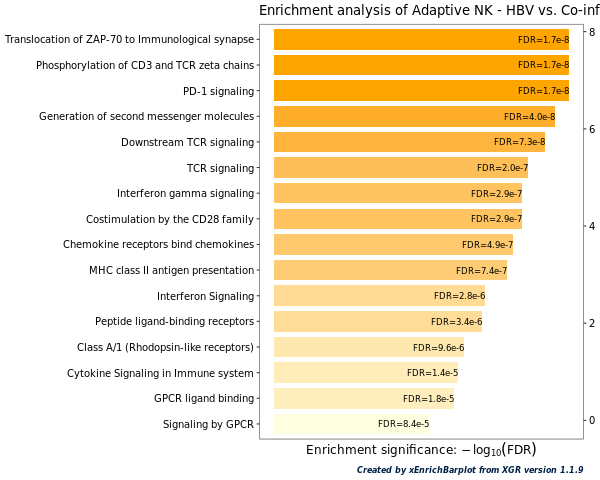

In [32]:
%%R -w 600
##enriched pathways in HBV Adaptive
bp <- xEnrichBarplot(REACTOME %>% 
                     #filter(grepl("Adaptive$", category)) %>% 
                     filter(grepl("overexpress", direction)), 
                     top_num='auto', displayBy="fdr")
bp + 
ggtitle("Enrichment analysis of Adaptive NK - HBV vs. Co-infection")

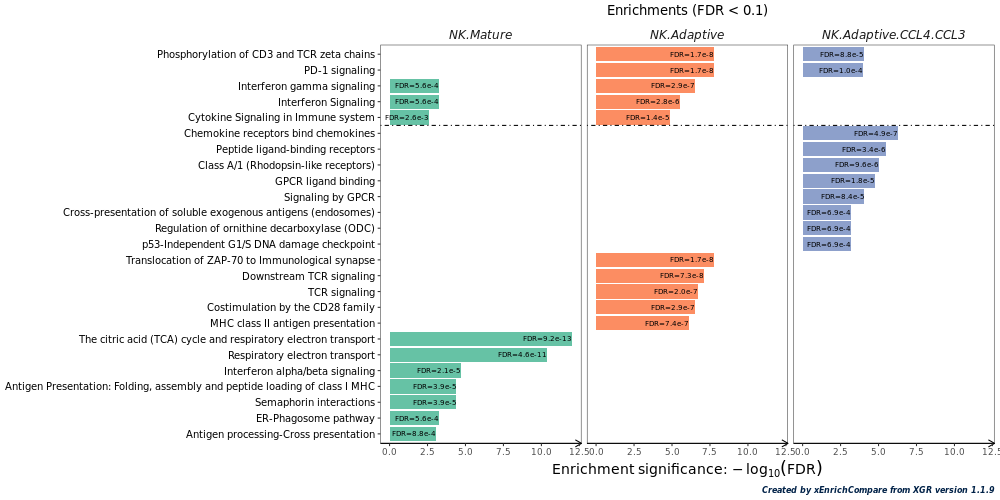

In [33]:
%%R -w 1000 -h 500
names(REACTOME_list) <- categories

ranked_reactome <- lapply(REACTOME_list, function(x){
    y <- x %>% 
  filter(!grepl("43S|CDK|Apop|ubiqu|ATP|Influenza|degredation|HIV|Circa|cone|Exon|Cell Cycle|BCR|messenger|Immune System|Axon|Adaptive Immune|Metabolism of proteins|mRNA|plate|Platelet|Hemos|regula", name)) %>%
    top_n(n = 10, wt = -log10(pvalue))
    return(y)
})
subset_enrich <- xEnrichCompare(ranked_reactome, displayBy="fdr", FDR.cutoff = 0.1)+
  scale_fill_brewer(palette='Set2') 

print(subset_enrich)

ggsave("/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/subset_reactome_enrich.pdf", width = 12, height = 5)



In [34]:
%%R

## Export all dataframes to csv
write.csv(merge_degs, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/DEseq2_allcontrasts_longformat.csv")
write.csv(allnk_reactome_hbv_co, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/DEseq2_reactome_longformat.csv")
write.csv(enrich_infection, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/DEseq2_co_differentially_expressed_infection.csv")
write.csv(REACTOME, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/XGR_REACTOME_NKsubsets_HBVvsCo.csv")





1.00s elapsed for 17390 iterations, 10 overlaps. Consider increasing 'max.time'.
1.00s elapsed for 14280 iterations, 24 overlaps. Consider increasing 'max.time'.
text repel complete in 29734 iterations (0.26s), 5 overlaps
1.00s elapsed for 18600 iterations, 18 overlaps. Consider increasing 'max.time'.
1.00s elapsed for 15480 iterations, 26 overlaps. Consider increasing 'max.time'.
text repel complete in 29458 iterations (0.24s), 5 overlaps


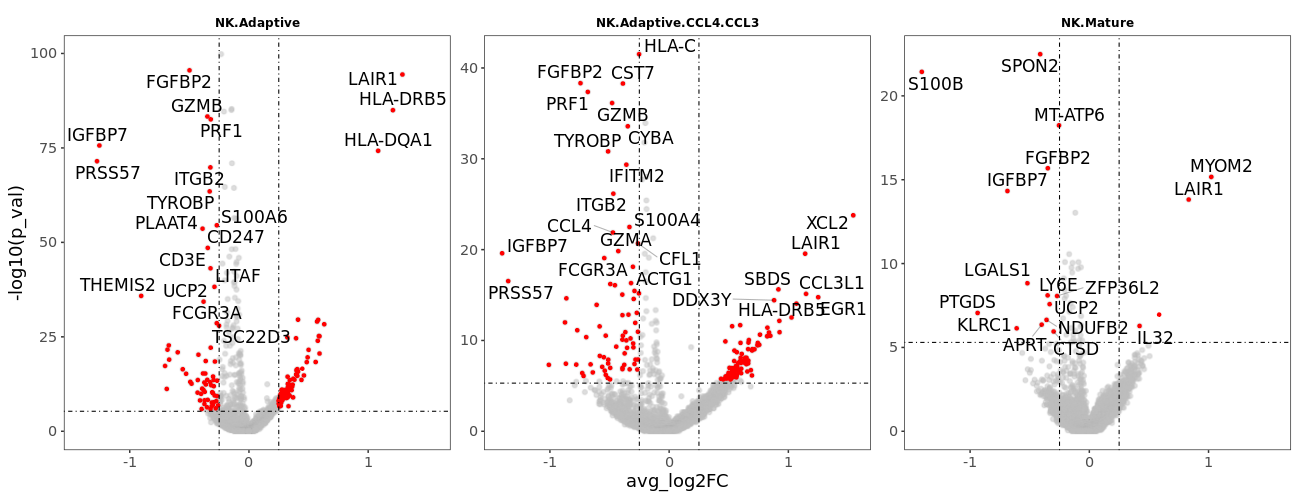

In [35]:
%%R -h 500 -w 1300
merge_degs <- lapply(names(dge_list), function(x){
    y <- data.table::rbindlist(dge_list[[x]])
    y$contrast = x
    return(y)
})

merge_degs <- data.table::rbindlist(merge_degs)



volcano_df <- merge_degs %>%
filter(!grepl("Prolifering", annotation)) %>%
filter(grepl("HBV_HIVvsHBV", contrast)) %>%
mutate(signif =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, "signif", NA))%>%
mutate(labels =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, gene, NA))

volcanoplots_HBVvsco <- volcano_df %>%
filter(!grepl("IGLV", gene)) %>%
ggplot(aes(avg_log2FC, -log10(p_val))) +
ggrastr::rasterise(geom_point(color="gray", alpha=0.5))+
geom_point(data = volcano_df %>% filter(signif == "signif"), color = "red")+
facet_wrap(~annotation, scales="free_y")+
geom_vline(xintercept=0.25,linetype="dotdash")+
geom_vline(xintercept=-0.25,linetype="dotdash")+
geom_hline(yintercept= -log10(0.000005), linetype="dotdash")+
ggrepel::geom_text_repel(aes(label = labels),
  verbose = TRUE,
  seed = 123,
  max.time = 1,
  max.iter = Inf,
  max.overlaps = 10,
  segment.alpha	=0.3,
  size = 6
)
pdf(file = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_volcano_subsets.pdf",width = 20,height = 7)
plot(volcanoplots_HBVvsco)
dev.off()

print(volcanoplots_HBVvsco)
